연비예측 모델 만들기 <hr>
- 데이터 : auto.csv
- 피  처 : 
- 타  겟 : 연비 (mpg)

In [2]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

- from sklearn.model_selection import train_test_split : 훈련용 데이터 및 테스트 데이터 split 하기

- StandardScaler : 표준화 스케일러

- MinMaxScaler: 데이터를 최소-최댓값 사이 범위로 스케일링하는 스케일러. (보통 0, 1 사이)   

- RobustScaler : 데이터의 중앙값(median)과 사분위수 범위(interquartile range, IQR)를 사용하여 이상치의 영향을 줄이고 스케일을 조정
    + 데이터에 이상치가 있는 경우나 데이터의 분포가 비대칭인 경우에 유용하게 사용

In [3]:
# 데이터 불러오기
data = '../data/auto-mpg.csv'

pd.read_csv(data).columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin', 'car name'],
      dtype='object')

- 1) mpg: 연비

- 2) cylinders: 실린더 개수

- 3) displacement: 배기량

- 4) horsepower: 마력

- 5) weight: 무게

- 6) acceleration: 엔진이 초당 얻을 수 있는 가속력

- 7) model year: 출시 년도

- 8) origin: 제조 장소(1: 미국 USA, 2: 유럽 EU, 3: 일본 JPN)

- 9) car name: 자동차 이름

In [4]:
autoDF = pd.read_csv(data)

In [5]:
# 데이터 확인
autoDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [6]:
# 결측치 확인 => 결측값 없음
autoDF.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [7]:
# 이상치 확인 => 마력 컬럼에서 ? 발견.

for col in autoDF.columns :
    print(f'{col} :', autoDF[col].sort_values(ascending=False))
    print()

mpg : 322    46.6
329    44.6
325    44.3
394    44.0
326    43.4
       ... 
103    11.0
67     11.0
25     10.0
26     10.0
28      9.0
Name: mpg, Length: 398, dtype: float64

cylinders : 0      8
86     8
230    8
231    8
232    8
      ..
81     4
243    3
334    3
71     3
111    3
Name: cylinders, Length: 398, dtype: int64

displacement : 8      455.0
95     455.0
13     455.0
6      454.0
7      440.0
       ...  
131     71.0
111     70.0
71      70.0
334     70.0
117     68.0
Name: displacement, Length: 398, dtype: float64

horsepower : 354      ?
374      ?
126      ?
330      ?
32       ?
      ... 
98     100
99     100
107    100
127    100
199    100
Name: horsepower, Length: 398, dtype: object

weight : 44     5140
103    4997
42     4955
90     4952
95     4951
       ... 
53     1773
345    1760
343    1755
144    1649
54     1613
Name: weight, Length: 398, dtype: int64

acceleration : 299    24.8
394    24.6
326    23.7
59     23.5
300    22.2
       ... 
116     9.5

In [8]:
# 이상치 '?'를 replace한 다음 int로 형 변환.
autoDF['horsepower'] = autoDF['horsepower'].replace({'?':0}).copy()
autoDF['horsepower']=autoDF['horsepower'].astype(int)
autoDF['horsepower']

0      130
1      165
2      150
3      150
4      140
      ... 
393     86
394     52
395     84
396     79
397     82
Name: horsepower, Length: 398, dtype: int32

In [9]:
# 상관계수 확인. 숫자만 비교.
autoDF_corr = autoDF.corr(numeric_only=True)
# 절댓값으로 변환하고 내림차순으로 정렬하여 연비와 상관계수가 높은 컬럼 확인.
abs(autoDF_corr['mpg']).sort_values(ascending=False)

mpg             1.000000
weight          0.831741
displacement    0.804203
cylinders       0.775396
horsepower      0.754276
model year      0.579267
origin          0.563450
acceleration    0.420289
Name: mpg, dtype: float64

In [10]:
corrList = autoDF_corr['mpg'].to_list()

In [11]:
# 타겟과 피처 결정.
# 필요한 컬럼만 저장.
autoDF = autoDF[['mpg','weight', 'displacement', 'cylinders', 'horsepower']]
targetSR = autoDF['mpg']
featureDF = autoDF[['weight', 'displacement', 'cylinders', 'horsepower']]

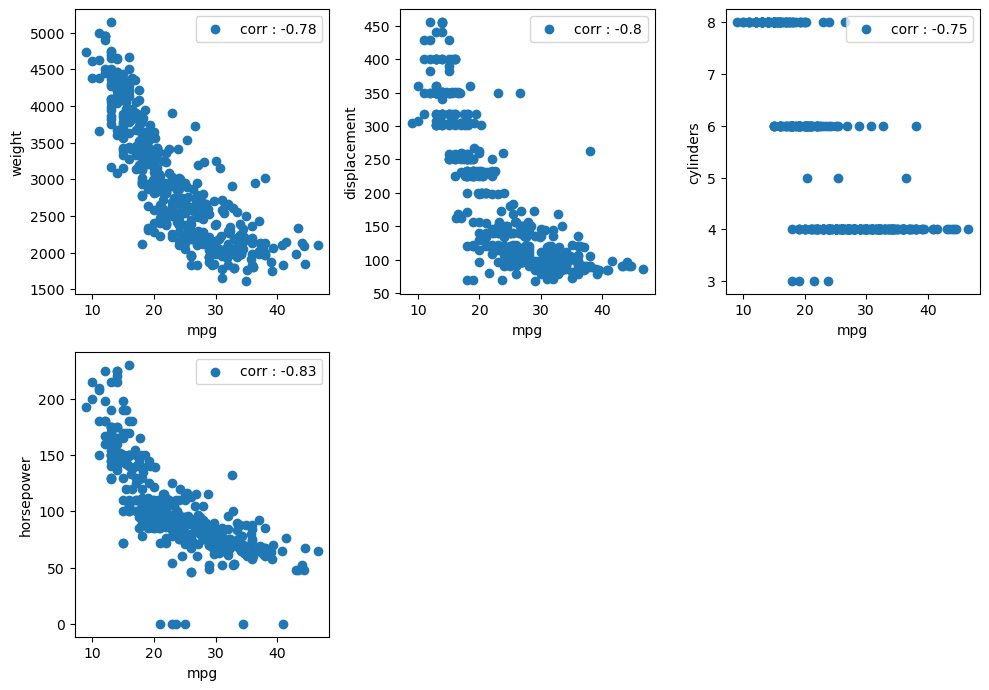

In [12]:
def print_feature(nrows, ncols, df, target, features, corrs) : 
    plt.figure(figsize=(10,10))
    for idx in range(len(features)):
        plt.subplot(nrows, ncols, idx+1)
        plt.scatter(df[target], df[features[idx]], label =f'corr : {corrs[idx]:.2}')
        plt.xlabel(target)
        plt.ylabel(features[idx])
        plt.legend()
    plt.tight_layout() # 간격 안 맞는 거 맞춰주는 건가..?
    plt.show()

print_feature(3, 3, autoDF, 'mpg', autoDF.columns[1:], corrList[1:])

- scale 차이가 크기 때문에 스케일링 진행 필요.

In [13]:
# 훈련용 데이터와 테스트용 데이터로 분리
# train:test = 8:2

X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.2, random_state=31)

In [14]:
# 훈련용 데이터 및 테스트용 데이터 확인
def print_train_test_data(X_train, X_test, y_train, y_test) :
    print(f'[훈련용] X_train : {X_train.shape}')
    print(X_train.head(2))
    print(f'\n[테스트용] X_test : {X_test.shape}')
    print(X_test.head(2))
    print(f'\n[훈련용] y_train : {y_train.shape}')
    print(y_train.head(2))
    print(f'\n[테스트용] y_test : {y_test.shape}')
    print(y_test.head(2))

print_train_test_data(X_train, X_test, y_train, y_test)

[훈련용] X_train : (318, 4)
     weight  displacement  cylinders  horsepower
8      4425         455.0          8         225
367    2605         112.0          4          88

[테스트용] X_test : (80, 4)
     weight  displacement  cylinders  horsepower
33     2634         232.0          6         100
363    3415         231.0          6         110

[훈련용] y_train : (318,)
8      14.0
367    28.0
Name: mpg, dtype: float64

[테스트용] y_test : (80,)
33     19.0
363    22.4
Name: mpg, dtype: float64


In [15]:
# 스케일링 
std_scaler = StandardScaler()
std_scaler.fit(X_train)

StandardScaler()

In [16]:
minmax_scaler = MinMaxScaler()
minmax_scaler.fit(X_train)

MinMaxScaler()

In [17]:
rb_scaler = RobustScaler()
rb_scaler.fit(X_train)

RobustScaler()

In [18]:
# 3가지 버전의 스케일된 데이터셋 준비
std_X_train = std_scaler.transform(X_train)
std_X_test = std_scaler.transform(X_test)

minmax_X_train = minmax_scaler.transform(X_train)
minmax_X_test = minmax_scaler.transform(X_test)

rb_X_train = rb_scaler.transform(X_train)
rb_X_test = rb_scaler.transform(X_test)

In [19]:
# 학습 진행 
def print_score(n, modelname, scaled_x_train, scaled_x_test, name) :
    train_scoreList =[]
    test_scoreList =[]
    for i in range(n) :
        model = modelname()
        model.fit(scaled_x_train, y_train)
        train_score = model.score(scaled_x_train, y_train)
        test_score = model.score(scaled_x_test, y_test)
        train_scoreList.append(train_score)
        test_scoreList.append(test_score)

    print(f'[{name} 모델파라미터] ====>\ncoef_: {model.coef_}\nintercept_ : {model.intercept_}')
    print(f'Train Score{i+1} : {train_score} --- Test Score{i+1} : {test_score}\n')
    print(f'max train score : {max(train_scoreList)} --- max test Score : {max(test_scoreList)}')
    print(f'min train score : {min(train_scoreList)} --- min test Score : {min(test_scoreList)}\n')

In [20]:
from sklearn.linear_model import LinearRegression
print_score(100, LinearRegression, std_X_train, std_X_test, 'std')
print()
print_score(100, LinearRegression, minmax_X_train, minmax_X_test, 'minmax')
print()
print_score(100, LinearRegression, rb_X_train, rb_X_test, 'robust')

[std 모델파라미터] ====>
coef_: [-4.53933402 -0.48970521 -0.29288007 -1.20439213]
intercept_ : 23.40377358490566
Train Score100 : 0.6769528500288873 --- Test Score100 : 0.7940972277000504

max train score : 0.6769528500288873 --- max test Score : 0.7940972277000504
min train score : 0.6769528500288873 --- min test Score : 0.7940972277000504


[minmax 모델파라미터] ====>
coef_: [-18.36629002  -1.82885053  -0.86072802  -6.92736376]
intercept_ : 34.74332637968485
Train Score100 : 0.6769528500288873 --- Test Score100 : 0.7940972277000503

max train score : 0.6769528500288873 --- max test Score : 0.7940972277000503
min train score : 0.6769528500288873 --- min test Score : 0.7940972277000503


[robust 모델파라미터] ====>
coef_: [-7.04095975 -0.73957392 -0.68858242 -1.48335941]
intercept_ : 25.19167219061812
Train Score100 : 0.6769528500288874 --- Test Score100 : 0.7940972277000504

max train score : 0.6769528500288874 --- max test Score : 0.7940972277000504
min train score : 0.6769528500288874 --- min test Sc

In [35]:
from sklearn.neighbors import KNeighborsRegressor
def print_score_k(n, modelname, scaled_x_train, scaled_x_test, name) :
    train_scoreList =[]
    test_scoreList =[]
    for k in range(1, n) :
        model = modelname(n_neighbors=k)
        model.fit(scaled_x_train, y_train)
        train_score = model.score(scaled_x_train, y_train)
        test_score = model.score(scaled_x_test, y_test)
        train_scoreList.append(train_score)
        test_scoreList.append(test_score)
    max_k=test_scoreList.index(max(test_scoreList))
    print(f'{name} model')
    print(f'Train Score{k} : {train_score} --- Test Score{k} : {test_score}\n')
    print(f'max train score : {max(train_scoreList)} --- max test Score : {max(test_scoreList)}')
    print(f'min train score : {min(train_scoreList)} --- min test Score : {min(test_scoreList)}\n')
    plt.plot(train_scoreList, 'royalblue', label = 'Train Score')
    plt.plot(test_scoreList, 'tomato', label = 'Test Score')
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.legend()
    plt.show()
    print('max_k :', max_k)


std model
Train Score99 : 0.6827286310832688 --- Test Score99 : 0.8013730303287012

max train score : 0.9975975675174689 --- max test Score : 0.8433796877261688
min train score : 0.6827286310832688 --- min test Score : 0.6693976050764268



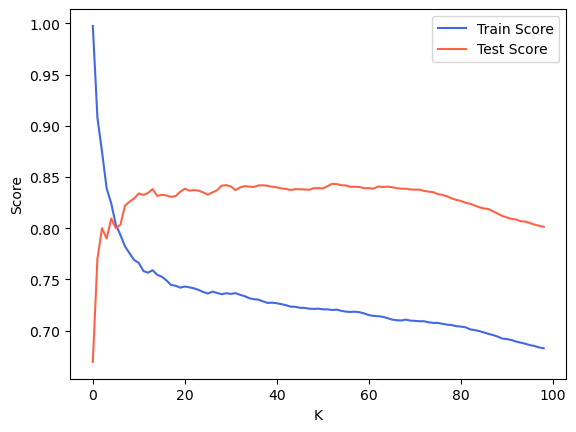

max_k : 52

minmax model
Train Score99 : 0.679764200113095 --- Test Score99 : 0.8043621124291462

max train score : 0.9975975675174689 --- max test Score : 0.8441772493205772
min train score : 0.679764200113095 --- min test Score : 0.6801025346874252



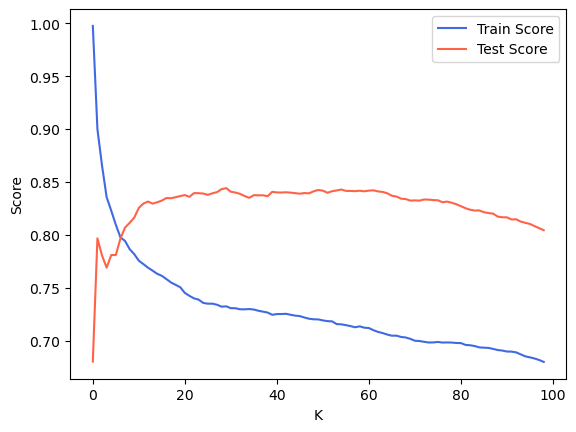

max_k : 29

robust model
Train Score99 : 0.6835392956724412 --- Test Score99 : 0.8036305245593708

max train score : 0.9975975675174689 --- max test Score : 0.8432850565203761
min train score : 0.6835392956724412 --- min test Score : 0.7361098540240176



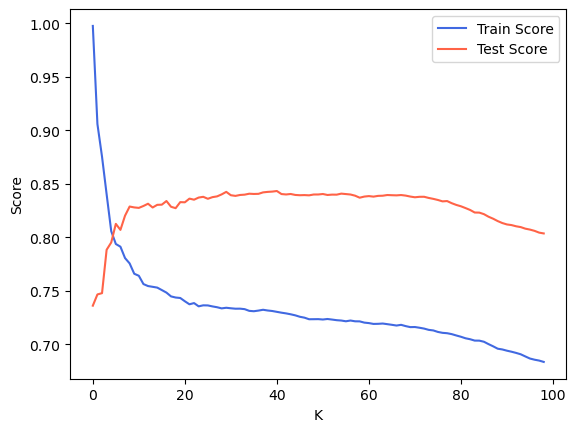

max_k : 40


In [36]:
print_score_k(100, KNeighborsRegressor, std_X_train, std_X_test, 'std')
print()
print_score_k(100, KNeighborsRegressor, minmax_X_train, minmax_X_test, 'minmax')
print()
print_score_k(100, KNeighborsRegressor, rb_X_train, rb_X_test, 'robust')

In [37]:
std_k = 52
model2 = KNeighborsRegressor(n_neighbors=std_k)
model2.fit(std_X_train, y_train) 

minmax_k = 29
model2 = KNeighborsRegressor(n_neighbors=minmax_k)
model2.fit(minmax_X_train, y_train) 

rb_k = 40
model2 = KNeighborsRegressor(n_neighbors=minmax_k)
model2.fit(rb_X_train, y_train) 

KNeighborsRegressor(n_neighbors=29)

In [38]:
print('std_train : ', model2.score(std_X_train, y_train))
print('std_test : ', model2.score(std_X_test, y_test))
print('minmax_test : ', model2.score(minmax_X_train, y_train))
print('minmax_test : ', model2.score(minmax_X_test, y_test))
print('robust_train : ', model2.score(rb_X_train, y_train))
print('robust_test : ', model2.score(rb_X_test, y_test)) # 31 -> 82%

std_train :  0.5880391913466955
std_test :  0.8294428605835014
minmax_test :  0.3311567185726789
minmax_test :  0.34712673311004594
robust_train :  0.7335895815696133
robust_test :  0.8401317635631761


In [39]:
# 성능 평가

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # 모델의 성능을 평가할 떄 사용함
import numpy as np

def evolution(scaled_X_test):

    y_pre = model2.predict(scaled_X_test) # 예측값 계산

    y_pre = np.round(y_pre, 1)

    print('[성능평가]')


    # 1) MSE
    print('1) 평균제곱오차:', mean_squared_error(y_test, y_pre))

    # 2) MAE
    print('2) 평균절대오차:', mean_absolute_error(y_test, y_pre))

    # 3) R2
    r2_scores = r2_score(y_test, y_pre)
    print('3) 루트제곱오차:', r2_scores)

    # 4) RMSE
    rmse = mean_squared_error(y_test, y_pre, squared=False)
    print('4) 평균제곱근오차:', rmse)

print('[std]')
evolution(std_X_test)
print()
print('[minmax]')
evolution(minmax_X_test)
print()
print('[robust]')
evolution(rb_X_test)

[std]
[성능평가]
1) 평균제곱오차: 11.779999999999998
2) 평균절대오차: 2.7624999999999997
3) 루트제곱오차: 0.8287211262240243
4) 평균제곱근오차: 3.4322004603461025

[minmax]
[성능평가]
1) 평균제곱오차: 45.025125
2) 평균절대오차: 5.0287500000000005
3) 루트제곱오차: 0.3453435737162537
4) 평균제곱근오차: 6.710076378104798

[robust]
[성능평가]
1) 평균제곱오차: 11.039375000000001
2) 평균절대오차: 2.57375
3) 루트제곱오차: 0.8394896674710812
4) 평균제곱근오차: 3.322555492388352
